# Run BMA on Background Galaxies

In this notebook, I edited the copa functions in order to run BMA on background galaxies using their true redshift.

In [1]:
import esutil
import numpy as np
import h5py
import os

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pyplot as plt

# Auxialiary Functions

In [3]:
def check_not_hf5(hf,path):
    return path not in hf.keys()

def delete_group(fname,path):
    fmaster = h5py.File(fname,'a')
    try:
        group   = fmaster[path]
    except:
        fmaster.close()
        return

    cols = group.keys()
    if len(cols)>0:
        for col in cols: del group[col]
    fmaster.close()
    
def stack_dict(in_list):
    columns = list(in_list[0].keys())
    new_dict= dict().fromkeys(columns)
    for col in columns:
        res = [mydict[col] for mydict in in_list]
        new_dict[col] = np.concatenate(res)
    return new_dict

def read_hdf5_file_to_dict(file,cols=None,indices=None,path='/'):
    hf = h5py.File(file, 'r')
    
    mygroup = hf[path]

    if cols is None: cols  = list(mygroup.keys())
    if indices is None: indices = np.arange(0,len(mygroup[cols[0]]),1,dtype=np.int64)

    mydict= dict().fromkeys(cols)
    for col in cols:
        mydict[col] = mygroup[col][:][indices]
    
    hf.close()

    return mydict
def write_bma_dict_temp_files(files,table,nsize,nchunks):
    columns = table.keys()
    idxs    = np.linspace(0,nsize,nchunks+1,dtype=np.int64)
    
    for i,file in enumerate(files):
        if not os.path.isfile(file):
            hf = h5py.File(file,'w')
            hf.create_group('bma')
            for col in columns:
                ilo,iup = idxs[i],idxs[i+1]
                hf.create_dataset('bma/%s/'%col,data=table[col][ilo:iup])
            hf.close()
    return files

# Loading the master file

In [4]:
mfile = '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/cosmoDC2_v1.1.4_copa.hdf5'

In [5]:
h=0.7
def make_bma_catalog_cut(fname,zmin=0.1,zmax=1.,rin=4,rout=6,dz=0.05,dmag_lim=0.,h=0.7):
    fmaster = h5py.File(fname, "a")

#     ## check if bma already exists
#     if check_not_hf5(fmaster['members'],'bma_bkg/mid'):
#         print('making bma cutout')
#         columns = fmaster['members/main']
#         radii   = fmaster['members/main/R'][:]*h
#         dmag    = fmaster['members/main/dmag'][:]
#         zoff    = fmaster['members/main/zoffset'][:]
#         mid     = fmaster['members/main/mid'][:]
#         z       = fmaster['members/main/z_true'][:]

#         #cut,    = np.where((radii<=rmax)&(dmag<=dmag_lim))
#         mask  = (z<=zmax)&(z>=zmin)
#         mask &= (radii<=rout)&(radii>=rin)
#         mask &= (np.abs(zoff)<=dz)
#         cut   = np.where(mask)[0]
#         try: fmaster.create_group('members/bma_bkg/')
#         except: print('group already exists')
            
#         fmaster.create_dataset('members/bma_bkg/mid/', data=mid[cut])
#         fmaster['members/bma_bkg/'].attrs['rout'] = rout
#         fmaster['members/bma_bkg/'].attrs['rin']  = rin
#         fmaster['members/bma_bkg/'].attrs['zmin'] = zmin
#         fmaster['members/bma_bkg/'].attrs['zmax'] = zmax
#         fmaster['members/bma_bkg/'].attrs['dmag'] = dmag_lim
#         fmaster['members/bma_bkg/'].attrs['nsize'] = int(cut.size)
#     else:
#         print('BMA cut already exists; overwrite=False')
#         fmaster.close()
#         delete_group(mfile,'members/bma_bkg/')
#         #make_bma_catalog_cut(fname,zmin=zmin,zmax=zmax,rin=rin,rout=rout,dz=dz,dmag_lim=dmag_lim)
        
    bma_indices = fmaster['members/bma_bkg/mid/'][:]
    fmaster.close()
    return bma_indices

In [16]:
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata

In [11]:
#indices = make_bma_catalog_cut(mfile,zmin=0.1,zmax=1.,rin=5.75,rout=6.,dz=0.05,dmag_lim=0.)

In [17]:
field_file= '/data/des61.a/data/johnny/CosmoDC2/runBMACosmoDC2/data/cosmoDC2_bma_field_galaxies.fits'
field = Table(getdata(field_file))

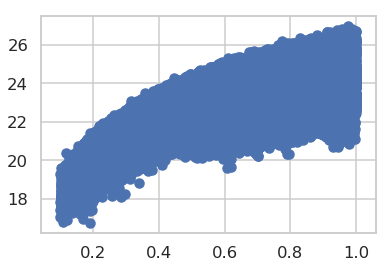

In [114]:
plt.scatter(field['z_true'],field['mag'][:,0])

In [116]:
def make_bma_input_temp_file(fname,files,indices,nsize,nchunks):
    mcols       = ['mid','CID','z_true','mag','magerr','Mr']                ## master/main/ columns
    out_columns = ['mid','CID','redshift','i','ierr','gr','ri','iz','grerr','rierr','izerr']
    
    #mydict = read_hdf5_file_to_dict(fname,indices=indices,cols=mcols,path='members/main/')
    mydict  = field

    out= dict().fromkeys(out_columns)
    for col in mcols:
        out[col] = mydict[col][:]

    out['indices'] = np.arange(0,out['mid'].size,1,dtype=np.int64)

    out['i']    = mydict['mag'][:,2]
    out['ierr'] = mydict['magerr'][:,2]

    out['gr']   = mydict['mag'][:,0] - mydict['mag'][:,1]
    out['ri']   = mydict['mag'][:,1] - mydict['mag'][:,2]
    out['iz']   = mydict['mag'][:,2] - mydict['mag'][:,3]

    out['grerr']= np.sqrt(mydict['magerr'][:,0]**2 + mydict['magerr'][:,1]**2)
    out['rierr']= np.sqrt(mydict['magerr'][:,1]**2 + mydict['magerr'][:,2]**2)
    out['izerr']= np.sqrt(mydict['magerr'][:,2]**2 + mydict['magerr'][:,3]**2)

    out['redshift'] = mydict['z_true']
    write_bma_dict_temp_files(files,out,nsize,nchunks)
    return out

In [117]:
nsize

100000

In [120]:
fname = mfile
nsize  = indices[:100000].size
nchunks= 100

root  = os.path.dirname(mfile)
bma_temp_input_files  = [root+'/temp_file/bkg_input_{:05d}.hdf5'.format(i+1) for i in range(nchunks)]
bma_temp_output_files = [root+'/temp_file/bkg_output_{:05d}.hdf5'.format(i+1) for i in range(nchunks)]

data = make_bma_input_temp_file(mfile,bma_temp_input_files,indices[:100000],nsize,nchunks)

In [121]:
bma_temp_input_files

['/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/temp_file/bkg_input_00001.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/temp_file/bkg_input_00002.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/temp_file/bkg_input_00003.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/temp_file/bkg_input_00004.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/temp_file/bkg_input_00005.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/temp_file/bkg_input_00006.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/temp_file/bkg_input_00007.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/temp_file/bkg_input_00008.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/temp_file/bkg_input_00009.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/temp_file/bkg_input_00010.hdf5',
 '/data/des61.a/data/johnny/CosmoDC2/sample2021/outputs/temp_file/bkg_input_00011.hdf5',
 '/data/des61.a/data/

# Visualizing the input sample

In [122]:
data['CID'].size

90119

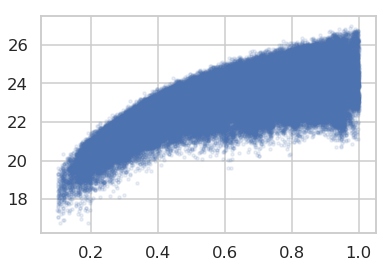

In [123]:
plt.scatter(data['z_true'],data['mag'][:,0],s=10,alpha=0.1)

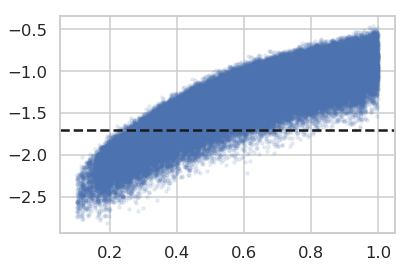

In [124]:
plt.scatter(data['z_true'],np.log10(data['rierr']),s=10,alpha=0.1)
plt.axhline(np.log10(0.02),color='k',ls='--')

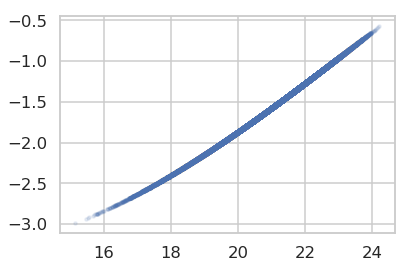

In [125]:
plt.scatter(data['mag'][:,2],np.log10(data['ierr']),s=10,alpha=0.1)

# Running BMA

In [126]:
from joblib import Parallel, delayed
import sys

sys.path.append('/home/s1/jesteves/git/ccopa/python/bma')
import smass

def bma_trigger(infiles,outfiles,inPath,
               nCores=2,batchStart=0,batchEnd=None,overwrite=False):
    if batchEnd is None: batchEnd = self.bma_nchunks

    batches = np.arange(batchStart,batchEnd,1,dtype=np.int64)

    print('starting parallel process')
    print('runing on the following batches:',batches)
    Parallel(n_jobs=nCores)(
        delayed(smass.calc_copa_v2)(infiles[i], outfiles[i], inPath) for i in batches)
    print('ended smass calc')

In [127]:
nCores = 60
libPath= '/data/des61.a/data/pbarchi/galaxyClusters/simha_miles_Nov2016/'
bma_trigger(bma_temp_input_files, bma_temp_output_files, libPath,
            nCores=nCores,batchStart=0,batchEnd=nchunks)

starting parallel process
('runing on the following batches:', array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))
ended smass calc


# Saving as a Fits File

In [128]:
from astropy.table import Table, vstack, join

def combine_hdf5_files(files,path='/'):
    """ Combine hdf5 files with same data structure
    """
    mylist = []
    count  = 0
    for file in files:
        if os.path.isfile(file):
            mydict = read_hdf5_file_to_dict(file,path=path)
            mylist.append(mydict)
        else:
            print('missing the temp file: %s'%(file))
            count+=1

    all_dict=stack_dict(mylist)
    return all_dict, count

In [129]:
table, nmissing = combine_hdf5_files(bma_temp_output_files,path='bma/')

In [130]:
new_indices = table['mid'][:]
out_data   = Table(table)

In [131]:
mcols       = ['mid','stellar_mass','CID','GID','RA','DEC','mag','magerr','R','dmag','z_true','zoffset','Mr']  ## master/main/ columns
mydict      = read_hdf5_file_to_dict(mfile,indices=new_indices,cols=mcols,path='members/main/')
data        = Table(mydict)

In [132]:
bma_data = join(data,out_data,keys=['mid','CID'])

we didn't miss any galaxy!

In [133]:
#1.*len(bma_data)/nsize

In [134]:
bma_data.colnames

['magerr',
 'z_true',
 'zoffset',
 'dmag',
 'CID',
 'mid',
 'GID',
 'RA',
 'mag',
 'Mr',
 'R',
 'DEC',
 'stellar_mass',
 'mass_weight_age_err',
 'gi_o',
 'index',
 'rabs',
 'gr_o_err',
 'gi_o_err',
 'iabs',
 'mass',
 'best_chisq',
 'mass_err',
 'kii_err',
 'kri_err',
 'ssfr_std',
 'kii',
 'best_model',
 'distmod',
 'best_zmet',
 'mcMass',
 'iobs',
 'taMass',
 'mass_weight_age',
 'kri',
 'zmet',
 'gr_o',
 'ssfr']

In [135]:
mass = 10**bma_data['mass']
masst= bma_data['stellar_mass']
zcls = bma_data['z_true']

(1.0, -1.5)

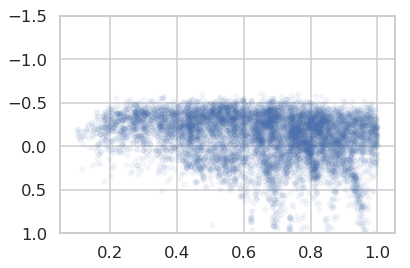

In [136]:
mask = (masst>10**(10.5))
plt.scatter(bma_data['z_true'][mask],np.log10(masst[mask]/mass[mask]),alpha=0.05,s=20)
plt.ylim(1.,-1.5)

(1.0, -1.5)

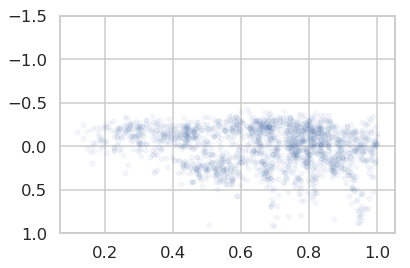

In [137]:
mask = (masst>10**(11.0))
plt.scatter(bma_data['z_true'][mask],np.log10(masst[mask]/mass[mask]),alpha=0.05,s=20)
plt.ylim(1.,-1.5)

Text(0.5,1,'Field Galaxies')

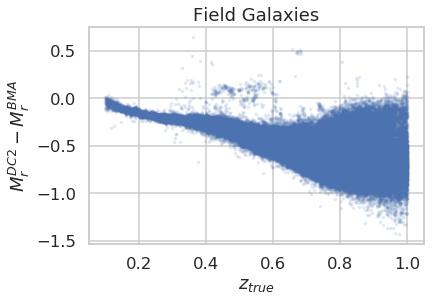

In [138]:
plt.scatter(bma_data['z_true'],(bma_data['rabs']-bma_data['Mr']),alpha=0.1,s=5)
plt.ylabel(r'$M_r^{DC2}-M_r^{BMA}$')
plt.xlabel(r'$z_{true}$')
plt.title('Field Galaxies')

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})


Text(0.5,1,'Field Galaxies')

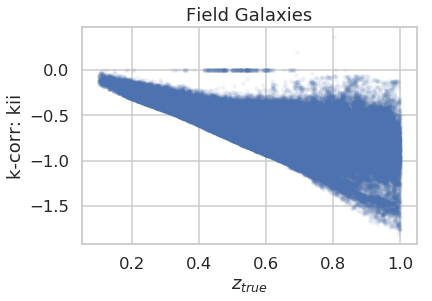

In [140]:
plt.scatter(bma_data['z_true'],bma_data['kii'],alpha=0.05,s=10)
plt.xlabel(r'$z_{true}$')
plt.ylabel(r'k-corr: kii')
plt.title('Field Galaxies')

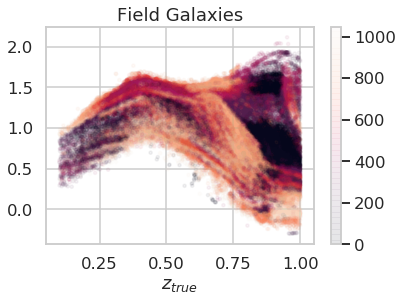

In [141]:
plt.scatter(bma_data['z_true'],bma_data['mag'][:,0]-bma_data['mag'][:,1],c=bma_data['best_model'],alpha=0.05,s=10)
plt.xlabel(r'$z_{true}$')
# plt.ylabel(r'$\chi^2$')
# plt.ylim(1e-7,100)
# plt.yscale('log')
plt.title('Field Galaxies')
plt.colorbar()

In [148]:
mask = bma_data['kii']==0

Text(0.5,1,'Field Galaxies')

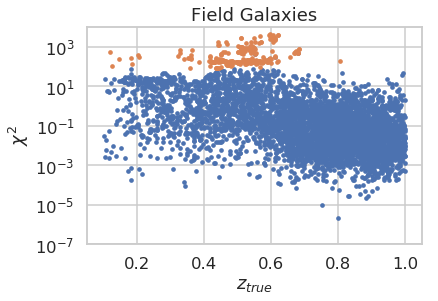

In [150]:
# plt.scatter(bma_data['z_true'][::20],bma_data['best_chisq'][::20],c=bma_data['best_model'][::20],alpha=0.7,s=10)
plt.scatter(bma_data['z_true'][::20],bma_data['best_chisq'][::20],s=10)
plt.scatter(bma_data['z_true'][mask],bma_data['best_chisq'][mask],s=10)
# plt.scatter(bma_data['z_true'][::20],bma_data['best_chisq'][::20])
plt.xlabel(r'$z_{true}$')
plt.ylabel(r'$\chi^2$')
plt.ylim(1e-7,10000)
plt.yscale('log')
plt.title('Field Galaxies')
# plt.colorbar()

(array([  1.,  17., 121., 345., 645., 845., 842., 714., 617., 503., 433.,
        295., 283., 281., 307., 417., 310., 253., 160.,  82.,  54.,  22.,
         19.,   9.,   3.,   3.,   0.,   0.,   0.,   1.]),
 array([-0.65985246, -0.60776629, -0.55568012, -0.50359396, -0.45150779,
        -0.39942163, -0.34733546, -0.2952493 , -0.24316313, -0.19107697,
        -0.1389908 , -0.08690463, -0.03481847,  0.0172677 ,  0.06935386,
         0.12144003,  0.17352619,  0.22561236,  0.27769852,  0.32978469,
         0.38187086,  0.43395702,  0.48604319,  0.53812935,  0.59021552,
         0.64230168,  0.69438785,  0.74647401,  0.79856018,  0.85064635,
         0.90273251]),
 <a list of 30 Patch objects>)

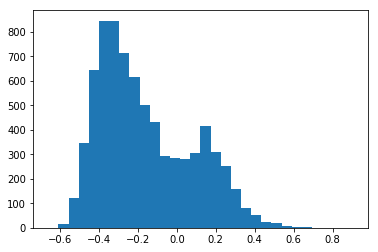

In [275]:
#mask = (masst>10**(11.1))#&(zcls>=0.42)&(zcls<=0.6)
mask2 = mask&(zcls>=0.42)&(zcls<=0.6)
plt.hist(np.log10(masst[mask2]/mass[mask2]),bins=30)

(array([36066., 36225., 36366., 36438., 36732., 36920., 36990., 37141.,
        37178., 37390.]),
 array([5.75000245, 5.77500217, 5.80000188, 5.82500159, 5.85000131,
        5.87500102, 5.90000073, 5.92500045, 5.95000016, 5.97499987,
        5.99999959]),
 <a list of 10 Patch objects>)

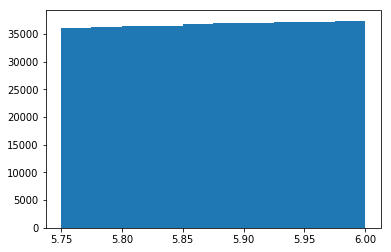

In [242]:
plt.hist(bma_data['R']*0.7)

In [151]:
outfile = root+'/cosmoDC2_v1.1.4_bma_bkg_ztrue_small.fits'
bma_data.write(outfile,format='fits',overwrite=True)

In [36]:
bma_data = Table(getdata(root+'/cosmoDC2_v1.1.4_bma_bkg_ztrue_x10_errors.fits'))

In [37]:
bma_data

magerr [4],z_true,zoffset,dmag,CID,mid,GID,RA,mag [4],Mr,R,DEC,stellar_mass,mass_weight_age_err,gi_o,index,rabs,gr_o_err,gi_o_err,iabs,mass,best_chisq,mass_err,kii_err,kri_err,ssfr_std,kii,best_model,distmod,best_zmet,mcMass,iobs,taMass,mass_weight_age,kri,zmet,gr_o,ssfr
float64,float64,float64,float64,int64,int64,int64,float64,float64,float32,float64,float64,float32,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.005691922059039469 .. 0.004706496002175418,0.17421725742860228,0.004344458409414786,-0.8320560176797684,91600026411,2181,1625017732,66.80728771716849,19.65122547326335 .. 17.71570720849284,-21.38117,8.230458525941087,-25.75125730134811,36701516000.0,4.6677002755027495,1.0923529014750786,0,-21.49707818217053,0.021637609238521836,0.02985332943948507,-21.882650127395944,10.858073228911213,3.37058084005101,0.052857279783242735,0.007319662498348055,0.3863001450625042,19.24620696965488,-0.27100942962442665,840,39.627247961196,0.03,10.514366061902606,18.01560726342448,10.669707081990934,5.608311660204671,0.11456251560098828,0.17421725742860228,0.7067809562496639,2.235963053556198e-14
0.01871427970322485 .. 0.018522207327527383,0.24794787375609162,-0.003990354857573991,1.3869518637620963,91600026411,2183,2187556888,66.09204464791368,21.46530323995912 .. 19.96739941610658,-20.044697,8.232460360415256,-26.233983424959167,3823599400.0,2.609391899850392,0.8108515520345305,1,-20.234591774088116,0.11577128784161296,0.17288625220046677,-20.521269244092615,9.984762097324799,0.10612130037211742,0.21689486232808267,0.06871532679005184,0.28695088182783834,15.689234515198596,-0.26851837130604295,913,40.48736601765292,0.03,9.809051757650707,20.234615144866346,9.928103784061218,5.142178899253494,0.01815909869845593,0.24794787375609162,0.5241740820300316,1.5552713880669354e-10
0.03528443985178749 .. 0.02908785422322012,0.16923878250647073,0.012679271676403562,1.9570559950432482,91600026411,2184,1625015236,66.62674389138436,22.302548713403358 .. 20.549460715966834,-18.567278,8.232713467863034,-25.414362421831616,768262600.0,3.282213988658182,0.9491550326119994,2,-18.63803994849231,0.09717853238207144,0.15088006525032116,-18.973049969911006,9.530285059620141,0.0808194022355542,0.1762527683877939,0.048738542970571466,0.33529928619016675,17.96572915567843,-0.220148896710141,924,39.55762034934836,0.03,9.269129136704493,20.804719276147498,9.405628510792804,5.270939225136209,0.11486112470855572,0.16923878250647073,0.6141450111933027,2.862703531460931e-12
0.013912366946744935 .. 0.008263538718571266,0.2851101089488839,0.029348885790548177,0.18964822902496792,91600026411,2191,1625080171,66.69417048901633,21.05046267895246 .. 18.741765932126288,-21.638964,8.239380770402024,-25.478448449565544,26277520000.0,3.9189596747451,1.0410899114394248,3,-21.837642715042968,0.036255096546355316,0.0554330431739904,-22.207069441364233,10.902838175638529,0.8060210066250131,0.08273888651877546,0.023518696775485126,0.3698719037518477,18.749863998265177,-0.4098272930720294,841,40.83455365842142,0.03,10.612067680120326,19.037311510129218,10.76359071455329,5.575906118596819,-0.0404005667507669,0.2851101089488839,0.6716631851181624,1.766834764158555e-12
0.005168826166513941 .. 0.006357032523973613,0.20477089463554066,0.029348885790548177,-0.3611948029469403,91600026411,2194,1625026544,66.80726200937875,19.480214281990317 .. 18.282357378914146,-21.288338,8.246442410792078,-25.7372984673918,34478424000.0,1.559580966973305,0.6516445592150635,4,-21.468788570076924,0.04169120977699896,0.06918498231379389,-21.71154659725997,10.265968817728261,0.9617047163046577,0.08983475761832618,0.035403883986513895,0.24375173484281468,11.681441615515812,-0.17990407948777853,957,40.018110995929504,0.03,10.176260033698405,18.48646847815731,10.292769830354535,4.493900965528967,0.06285394769526968,0.20477089463554066,0.40888653203201525,9.7407488

# Removing temp files

In [ ]:
def remove_files(files):
    for file in files:
        os.remove(file)

In [ ]:
#remove_files(bma_temp_input_files)
#remove_files(bma_temp_output_files)

In [185]:
def mag2nmgy(mag, magerr=None):
    """
    Name:
        mag2nmgy
    Purpose:
        Convert from magnitudes to nano-maggies.  The basic formula
        is 
            mag = 22.5-2.5*log_{10}(nanomaggies)
        The mag error can optionally be sent, in which case the inverse
        variance of the nanomaggies is returned.
    Calling Sequence:
        nmgy = mag2nmgy(mag)
        nmgy,ivar = mag2nmgy(mag, magerr=magerr)
            
    """
    mag = np.array(mag, ndmin=1, copy=False)

    nmgy = 10.0**( (22.5-mag)/2.5 )
    if magerr is not None:
        ivar = nmgy.copy()
        ivar[:] = 0.0

        w = np.where( (nmgy > 0.) & (magerr > 0.) )

        if w[0].size > 0:
            a = 2.5/np.log(10)
            ivar[w] = ( a/nmgy[w]/magerr[w] )**2

        return nmgy, ivar
    else:
        return nmgy
    
def nmgy2lups(nmgy, ivar=None, band=None):
    """
    Name:
        nmgy2lups
    Purpose:
        Convert from nano-maggies to luptitudes, which are asinh based
        mags.  The default parameters for SDSS are used.
    Calling Sequence:
        lup = nmgy2lups(nmgy)
        lup,err = nmgy2lups(nmgy, ivar=ivar)
    Inputs:
        nmgy: SDSS nanomaggies.  Can either be a [5,Nobj] array or
            an array for a single band, in which case the band must
            be given.
    Keywords:
        ivar: The inverse variance.  Must have the same shape as nmgy.
            If ivar is sent, then a tuple (lup,luperr) is returned.
    Outputs:
        The luptitudes as asinh values.  If ivar= is sent, a tuple
        is returned (lup,luperr)
    """
    s = nmgy.shape
    if ivar is not None:
        sivar = ivar.shape
        if len(sivar) != len(s):
            raise ValueError("ivar and fluxes must be same shape")
        for i in xrange(len(s)):
            if sivar[i] != s[i]:
                raise ValueError("ivar and fluxes must be same shape")

    if len(s) == 2:
        if s[1] != 4:
            raise ValueError("Either enter a 1-d array or a (nobj, 5) array")
        nband = 4
        band=[0,1,2,3]
    else:
        if band is None:
            raise ValueError("For 1-d input, specify a band in [0,4]")
        nband = 1
        try:
            if len(band) != 1:
                raise ValueError("for 1-d input, enter a single band")
        except:
            band = [band]

    # make sure band values makes sense
    for b in band:
        if b not in [0,1,2,3]:
            raise ValueError("band must be in [0,4]")

    lups = np.array( nmgy, copy=True )
    lups[:] = -9999.0
    if ivar is not None:
        lups_err = np.array(ivar, copy=True)
        lups_err[:] = -9999.0

    for b in band:
        if nband == 1:
            lups[:] = _nmgy2lups_1band(nmgy, b)
            if ivar is not None:
                lups_err[:] = _ivar2luperr_1band(nmgy, ivar, b)
        else:
            lups[:,b] = _nmgy2lups_1band(nmgy[:,b], b)
            if ivar is not None:
                lups_err[:,b] = _ivar2luperr_1band(nmgy[:,b], ivar[:,b], b)

    if ivar is not None:
        return lups, lups_err
    else:
        return lups

def lups2nmgy(lups, err=None, band=None):
    """
    Name:
        lups2nmgy
    Purpose:
        Convert from luptitudes to nano-maggies. The default parameters 
        for SDSS are used.
    Calling Sequence:
        nmgy= lups2nmgy(lups)
        nmgy,ivar= lups2nmgy(lups,err=err)
    Inputs:
        lups: The luptitudes as asinh values. Can either be a [5,Nobj] array or
         an array for a single band, in which case the band must
         be given.
    Keywords:
       err: uncertainty on the lups.  Must have the same shape as nmgy.
            If err is sent, then a tuple (nmgy,ivar) is returned.
    Outputs:
         SDSS nanomaggies. If err= is set then the inverse variance is returned
         as well as (nmgy,ivar)
    """
    s = lups.shape
    if err is not None:
        serr = err.shape
        if len(serr) != len(s):
            raise ValueError("err and lups must be same shape")
        for i in xrange(len(s)):
            if serr[i] != s[i]:
                raise ValueError("err and lups must be same shape")

    if len(s) == 2:
        if s[1] != 5:
            raise ValueError("Either enter a 1-d array or a (nobj, 5) array")
        nband = 5
        band=[0,1,2,3,4]
    else:
        if band is None:
            raise ValueError("For 1-d input, specify a band in [0,4]")
        nband = 1
        try:
            if len(band) != 1:
                raise ValueError("for 1-d input, enter a single band")
        except:
            band = [band]

    # make sure band values makes sense
    for b in band:
        if b not in [0,1,2,3,4]:
            raise ValueError("band must be in [0,4]")

    nmgy = np.array( lups, copy=True )
    nmgy[:] = -9999.0
    if err is not None:
        ivar = np.array(err, copy=True)
        ivar[:] = -9999.0

    for b in band:
        if nband == 1:
            nmgy[:] = _lups2nmgy_1band(lups, b)
            if err is not None:
                ivar[:] = _luperr2ivar_1band(lups, err, b)
        else:
            nmgy[:,b] = _lups2nmgy_1band(lups[:,b], b)
            if err is not None:
                ivar[:,b] = _luperr2ivar_1band(lups[:,b], err[:,b], b)

    if err is not None:
        return nmgy, ivar
    else:
        return nmgy

_bvalues=[0.9, 1.2, 1.8, 7.4]
_log10 = np.log(10.0)

ln10_min10 = -23.02585
def _nmgy2lups_1band(nmgy, band):
    b=_bvalues[band]
    lups = 2.5*(10.0-np.log10(b)) - 2.5*np.arcsinh(5.0*nmgy/b)/_log10
    return lups

def _ivar2luperr_1band(nmgy, ivar, band):
    b=_bvalues[band]
    lups_err = np.array(ivar, copy=True)
    lups_err[:] = -9999.0
    w,=np.where(ivar > 0.0)
    if w.size > 0:
        terr = 1.0/np.sqrt(ivar[w])
        lups_err[w] = 2.5*terr
        lups_err[w] /= 0.2*b*_log10*np.sqrt(1.0 + (5.0*nmgy[w]/b)**2 )
    return lups_err

def _lups2nmgy_1band(lups, band):
    b=_bvalues[band]
    nmgy= b/5.*np.sinh(-lups*np.log(10.)/2.5-ln10_min10-np.log(b))
    return nmgy

def _luperr2ivar_1band(lups, err, band):
    b=_bvalues[band]
    df= b/5.*np.cosh(-lups*np.log(10.)/2.5-ln10_min10-np.log(b))\
        *err*np.log(10.)/2.5
    return 1./df**2.


In [173]:
mag = bma_data['mag']
magerr = bma_data['magerr']

## convert to flux
nmgy,ivar = mag2nmgy(mag, magerr=magerr)

## convert to lupmag
lup,err = nmgy2lups(nmgy, ivar=ivar)

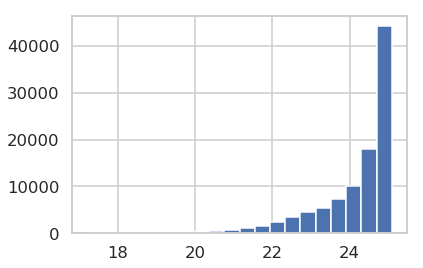

In [190]:
_ = plt.hist(lup[:,0],bins=20)